In [7]:

from google.colab import files
import os
import shutil

uploaded = files.upload()
dest_path = "/content/data/"
os.makedirs(os.path.dirname(dest_path), exist_ok=True)
#shutil.move("/content/InputDataEnergyLargeInstance.xlsx", dest_path)
shutil.move("/content/InputDataEnergySmallInstance.xlsx", dest_path)
shutil.rmtree("/content/sample_data/", ignore_errors=True, onerror=None)


Saving InputDataEnergySmallInstance.xlsx to InputDataEnergySmallInstance.xlsx


In [8]:
!pip install pulp

In [9]:
# Import PuLP modeler functions
from pulp import *
import pandas as pd
import numpy as np

In [13]:
InputData = "/content/data/InputDataEnergySmallInstance.xlsx"

In [14]:
# Input Data Preparation
def read_excel_data(filename, sheet_name):
  data = pd.read_excel(filename, sheet_name=sheet_name, header=None)
  values = data.values
  if min(values.shape) == 1:  # This If is to make the code insensitive to column-wise or row-wise expression
      if values.shape[0] == 1:
          values = values.tolist()
      else:
          values = values.transpose()
          values = values.tolist()
      return values[0]
  else:
      data_dict = {}
      if min(values.shape) == 2:  # For single-dimension parameters in Excel
          if values.shape[0] == 2:
              for i in range(values.shape[1]):
                  data_dict[i] = values[1][i]
          else:
              for i in range(values.shape[0]):
                  data_dict[i] = (values[i][0],values[i][1])

      else:  # For two-dimension (matrix) parameters in Excel
          for i in range(values.shape[0]):
              for j in range(values.shape[1]):
                  data_dict[(i, j)] = values[i][j]
      return data_dict

In [15]:
#parameters
Nodes = read_excel_data(InputData, "Nodes")
NodesCord = read_excel_data(InputData, "NodesCord")
V = [i for i in range(0,Nodes[0])]
E = [(i, j) for i in range(0, Nodes[0] ) for j in range(0, Nodes[0] )]
l={}
for i in range(Nodes[0]):
    for j in range(Nodes[0]):
        l[(i,j)]=((NodesCord[i][0]-NodesCord[j][0])**2+(NodesCord[i][1]-NodesCord[j][1])**2)**(1/2)

V0 = read_excel_data(InputData, "SourceNum")
for i in range(len(V0)):
  V0[i]=V0[i]-1

FixedUnitCost = read_excel_data(InputData, "FixedUnitCost")
vfix_thetaijfix = read_excel_data(InputData, "vfix(thetaijfix)")
vvar_thetaijvar = read_excel_data(InputData, "vvar(thetaijvar)")
cvar_cijvar = read_excel_data(InputData, "cvar(cijvar)")
cheat_ciheat = read_excel_data(InputData, "cheat(ciheat)")
com_cijom = read_excel_data(InputData, "com(cijom)")
crev_cijrev = read_excel_data(InputData, "crev(cijrev)")
Tflh_Tiflh = read_excel_data(InputData, "Tflh(Tiflh)")
Betta = read_excel_data(InputData, "Betta")
Lambda = read_excel_data(InputData, "Lambda")
Alpha = read_excel_data(InputData, "Alpha")
EdgesDemandPeak_dij = read_excel_data(InputData, "EdgesDemandPeak(dij)")
EdgesDemandAnnual_dij =  read_excel_data(InputData, "EdgesDemandAnnual(Dij)")
Cmax_cijmax = read_excel_data(InputData, "Cmax(cijmax)")
SourceMaxCap_Qimax = read_excel_data(InputData, "SourceMaxCap(Qimax)")
pumd_pijumd = read_excel_data(InputData, "pumd(pijumd)")

In [16]:
#decision variables
X=LpVariable.dicts("X",(V,V),lowBound=0,upBound=1,cat="Binary")
P_Out=LpVariable.dicts("P_Out",(V,V),lowBound=0,upBound=None,cat="Continuous")
P_In=LpVariable.dicts("P_In",(V,V),lowBound=0,upBound=None,cat="Continuous")
problem=LpProblem("problem",LpMinimize)

In [17]:

# Constraint 1
"""sum_x =[]
for i in range(len(V)):
  for j in range(len(V)):
    sum_x.append(X[i][j])"""
problem += lpSum([X[i][j] for i in range(len(V)) for j in range(len(V))]) == len(V) - 1

# Constraint 2
for i in range(len(V)):
    for j in range(i+1,len(V)):
        problem += lpSum([X[i][j],X[j][i]]) <= 1

# Constraint 3
for (i,j) in E:
    eta = 1 - vvar_thetaijvar[(i,j)]*l[(i,j)]
    delta = EdgesDemandPeak_dij[(i,j)]*Betta[0]*Lambda[0] + l[(i,j)]*vfix_thetaijfix[(i,j)]
    problem += lpSum([eta*P_In[i][j],-P_Out[i][j],-delta*X[i][j]]) == 0

# Constraint 4
"""for j in range(4,len(V)):
    sum_out_in= []
    for i in range(len(V)):
        if i != j:
            sum_out_in.append(P_Out[i][j])
            sum_out_in.append(-P_In[j][i])
            problem +=lpSum(sum_out_in) == 0"""
for j in range(0,len(V)):
  if j not in V0:
    problem += lpSum(P_Out[i][j]-P_In[j][i] for i in range(len(V)) if i != j) == 0

# Constraint 5
for i in range(len(V)):
  for j in range(len(V)):
    problem += lpSum([P_In[i][j],-X[i][j]*Cmax_cijmax[(i,j)] ]) <= 0

# Constraint 6
for v in V0:
  for i in range(len(V)):
    if i != v:
      problem += X[i][v] == 0
      problem += P_In[i][v] == 0
"""problem += sum_X == 0"""

# Constraint 7
for v in V0:
  sum_PIN =[]
  for i in range(len(V)):
      if i != v:
          sum_PIN.append(P_In[v][i])
  problem += lpSum(sum_PIN) <= SourceMaxCap_Qimax[v]

# Constraint 8
for i in range(0,len(V)):
  if i not in V0:
    summ=[]
    for j in range(len(V)):
        if j!=i:
          summ.append(X[j][i])
    problem += lpSum(summ) >= 1

# Constraint 9
for i in range(len(V)):
  for j in range(len(V)):
    problem += P_In[i][j] >= 0
    problem += P_Out[i][j] >= 0
    problem += X[i][j] >= 0
    problem += X[i][j] <= 1

In [18]:
#objective function
n=len(V)

#revenue
revenue=0
for i in range(n):
  for j in range(n):
    revenue+=crev_cijrev[(i,j)]*EdgesDemandAnnual_dij[(i,j)]*Lambda[0]*X[i][j]

#Heat generation
heat_generation=0
for j in range(n):
  for v in V0:
    heat_generation+=P_In[v][j]*Tflh_Tiflh[0]*cheat_ciheat[v]
heat_generation=(1/Betta[0])*heat_generation

#maintenance
maintenance=0
for i in range(n):
  for j in range(n):
    maintenance+=com_cijom[(i,j)]*l[(i,j)]*X[i][j]

#total fixed investment cost
total_fixed_investment_cost=0
for i in range(Nodes[0]):
    for j in range(Nodes[0]):
        total_fixed_investment_cost+=l[(i,j)]*FixedUnitCost[0]*X[i][j]*Alpha[0]

#total variable investment cost
total_var=0
for i in range(n):
  for j in range(n):
    total_var+=cvar_cijvar[(i,j)]*P_In[i][j]*l[(i,j)]*Alpha[0]

#unmet demand
unmet_demand=0
for i in range(n):
  for j in range(i+1,n):
    unmet_demand+=lpSum([1,-X[i][j],-X[j][i]])*pumd_pijumd[(i,j)]*EdgesDemandAnnual_dij[(i,j)]

#objective function
objective_function=-(revenue-heat_generation-maintenance-total_fixed_investment_cost-total_var-unmet_demand)
problem+=objective_function
problem.solve()
LpStatus[problem.status]


'Optimal'

In [19]:
for v in problem.variables():
  print(v.name,"=",v.varValue)
print("objective_function","=",value(problem.objective))


P_In_0_0 = 0.0
P_In_0_1 = 0.0
P_In_0_2 = 0.0
P_In_0_3 = 0.0
P_In_0_4 = 0.0
P_In_0_5 = 0.0
P_In_0_6 = 0.0
P_In_0_7 = 0.0
P_In_1_0 = 0.0
P_In_1_1 = 0.0
P_In_1_2 = 292.57299
P_In_1_3 = 0.0
P_In_1_4 = 0.0
P_In_1_5 = 0.0
P_In_1_6 = 0.0
P_In_1_7 = 0.0
P_In_2_0 = 0.0
P_In_2_1 = 0.0
P_In_2_2 = 0.0
P_In_2_3 = 0.0
P_In_2_4 = 0.0
P_In_2_5 = 0.0
P_In_2_6 = 0.0
P_In_2_7 = 0.0
P_In_3_0 = 287.93
P_In_3_1 = 614.50812
P_In_3_2 = 0.0
P_In_3_3 = 0.0
P_In_3_4 = 585.83934
P_In_3_5 = 0.0
P_In_3_6 = 672.73173
P_In_3_7 = 305.28467
P_In_4_0 = 0.0
P_In_4_1 = 0.0
P_In_4_2 = 0.0
P_In_4_3 = 0.0
P_In_4_4 = 0.0
P_In_4_5 = 0.0
P_In_4_6 = 0.0
P_In_4_7 = 0.0
P_In_5_0 = 0.0
P_In_5_1 = 0.0
P_In_5_2 = 0.0
P_In_5_3 = 0.0
P_In_5_4 = 0.0
P_In_5_5 = 0.0
P_In_5_6 = 0.0
P_In_5_7 = 0.0
P_In_6_0 = 0.0
P_In_6_1 = 0.0
P_In_6_2 = 0.0
P_In_6_3 = 0.0
P_In_6_4 = 0.0
P_In_6_5 = 279.56807
P_In_6_6 = 0.0
P_In_6_7 = 0.0
P_In_7_0 = 0.0
P_In_7_1 = 0.0
P_In_7_2 = 0.0
P_In_7_3 = 0.0
P_In_7_4 = 0.0
P_In_7_5 = 0.0
P_In_7_6 = 0.0
P_In_7_7 = 0.0
P

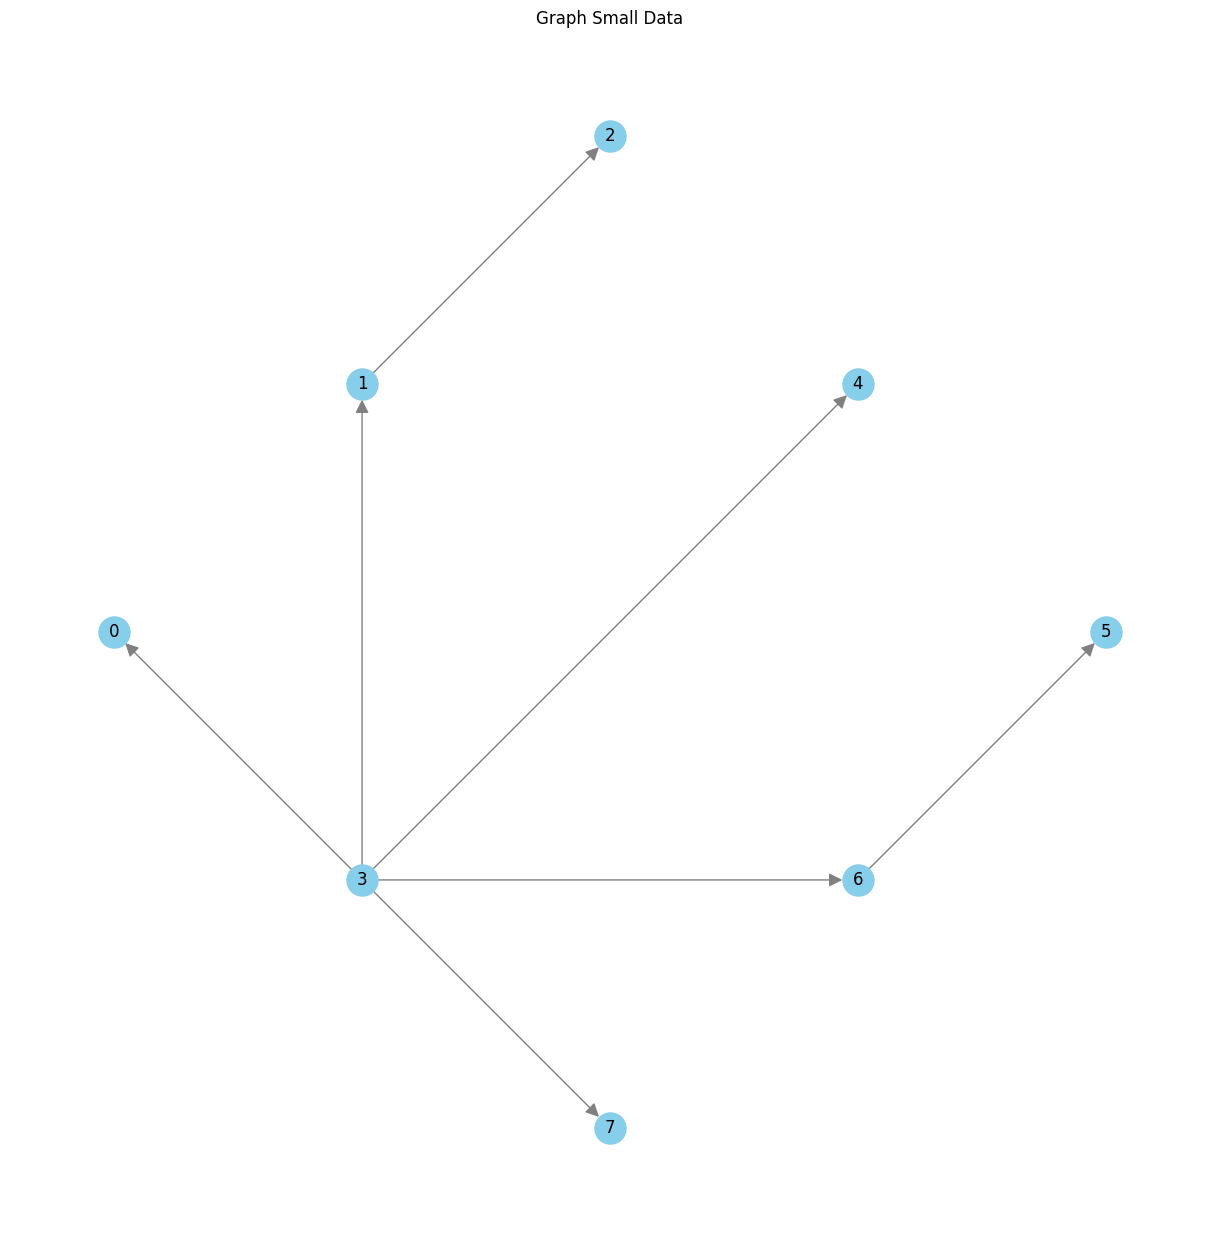

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# Extract edges from the solution
edges = []
for var in problem.variables():
    if var.name.startswith("X_") and var.varValue == 1:
        # Parse indices (e.g., "X_0_25" -> (0, 25))
        parts = var.name.split("_")
        i = int(parts[1])
        j = int(parts[2])
        edges.append((i, j))

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(V)

# Add edges
G.add_edges_from(edges)

# Extract node coordinates from NodesCord (convert np.int64 to float)
pos = {node: (float(NodesCord[node][0]), float(NodesCord[node][1])) for node in NodesCord}

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500,
        edge_color='gray', arrows=True, arrowsize=20)
plt.title("Graph Small Data")
plt.show()